Movies Recommendation System


dataset link - https://www.kaggle.com/datasets/grouplens/movielens-20m-dataset


In [ ]:
import pandas as pd

# Load ratings data
ratings_df = pd.read_csv('/content/rating.csv')

# Load movie data
movies_df = pd.read_csv('/content/movie.csv')

# Merge ratings and movie data
merged_df = pd.merge(ratings_df, movies_df, on='movieId', how='left')

# Display the first few rows of the merged dataframe
print(merged_df.head())


   userId  movieId  rating            timestamp  \
0       1        2     3.5  2005-04-02 23:53:47   
1       1       29     3.5  2005-04-02 23:31:16   
2       1       32     3.5  2005-04-02 23:33:39   
3       1       47     3.5  2005-04-02 23:32:07   
4       1       50     3.5  2005-04-02 23:29:40   

                                               title  \
0                                     Jumanji (1995)   
1  City of Lost Children, The (Cité des enfants p...   
2          Twelve Monkeys (a.k.a. 12 Monkeys) (1995)   
3                        Seven (a.k.a. Se7en) (1995)   
4                         Usual Suspects, The (1995)   

                                   genres  
0              Adventure|Children|Fantasy  
1  Adventure|Drama|Fantasy|Mystery|Sci-Fi  
2                 Mystery|Sci-Fi|Thriller  
3                        Mystery|Thriller  
4                  Crime|Mystery|Thriller  


In [ ]:
tags_df = pd.read_csv('/content/tag.csv')

In [ ]:
merged_df = pd.merge(merged_df, tags_df, on=['userId', 'movieId'], how='left')

In [ ]:
print(merged_df.isnull().sum())

userId               0
movieId              0
rating               1
timestamp_x          1
title                0
genres               0
tag            1775732
timestamp_y    1775732
dtype: int64


In [ ]:
# Drop rows with missing values in rating and timestamps
merged_df.dropna(subset=['rating', 'timestamp_x', 'timestamp_y'], inplace=True)

# Fill missing values in the tag column with a placeholder value (e.g., 'NoTag')
merged_df['tag'].fillna('NoTag', inplace=True)

# Check again for missing values
print(merged_df.isnull().sum())


userId         0
movieId        0
rating         0
timestamp_x    0
title          0
genres         0
tag            0
timestamp_y    0
dtype: int64


In [ ]:
merged_df.dropna(inplace=True)

In [ ]:
print(merged_df.describe())

             userId        movieId        rating
count  50047.000000   50047.000000  50047.000000
mean    6917.362659   33136.995724      3.723180
std     3609.094942   36645.954746      1.014717
min       65.000000       1.000000      0.500000
25%     4087.000000    2355.000000      3.000000
50%     6988.000000    7301.000000      4.000000
75%    10616.000000   64957.000000      4.500000
max    12087.000000  130073.000000      5.000000


In [ ]:
import numpy as np

# Define functions for winsorization and capping
def winsorize(series):
    q1 = series.quantile(0.01)
    q99 = series.quantile(0.99)
    series = np.where(series < q1, q1, series)
    series = np.where(series > q99, q99, series)
    return series

def cap(series, cap_value):
    return np.minimum(series, cap_value)

# Apply the transformations
merged_df['userId'] = winsorize(merged_df['userId'])
merged_df['movieId'] = winsorize(merged_df['movieId'])
merged_df['rating'] = cap(merged_df['rating'], 5)  # capping ratings at 5

# Check summary statistics after handling outliers
print(merged_df.describe())


In [ ]:
merged_df = merged_df[(merged_df['rating'] >= 0) & (merged_df['rating'] <= 5)]

In [ ]:
# Create user-item interaction matrix
interaction_matrix = merged_df.pivot_table(index='userId', columns='movieId', values='rating')

# Fill missing values with 0 (assuming no rating implies a rating of 0)
interaction_matrix.fillna(0, inplace=True)

# Display the user-item interaction matrix
print(interaction_matrix.head())


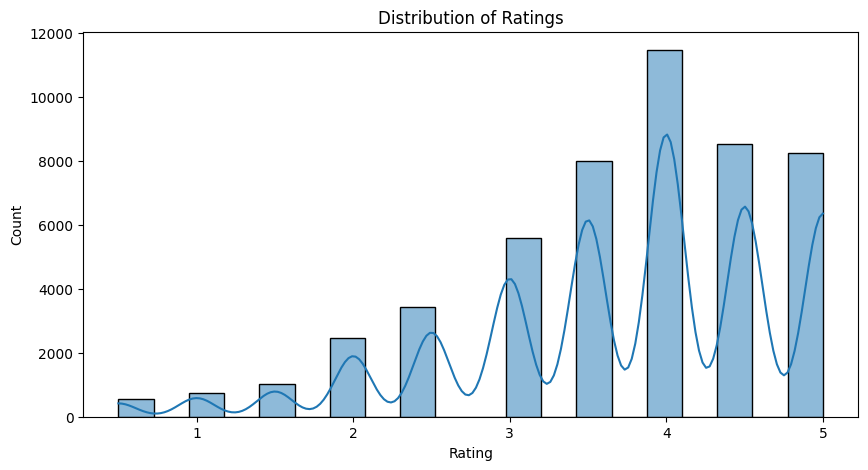

<ipython-input-11-82df62dee77c>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_rated_movies.index, x=top_rated_movies.values, palette='viridis')


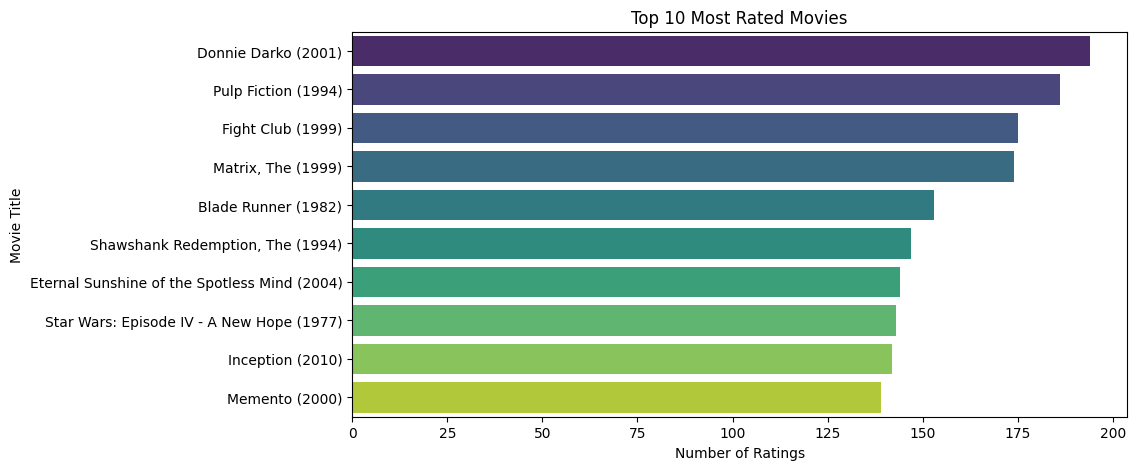

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot distribution of ratings
plt.figure(figsize=(10, 5))
sns.histplot(merged_df['rating'], bins=20, kde=True)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

# Analyze the most rated movies
top_rated_movies = merged_df['title'].value_counts().head(10)
plt.figure(figsize=(10, 5))
sns.barplot(y=top_rated_movies.index, x=top_rated_movies.values, palette='viridis')
plt.title('Top 10 Most Rated Movies')
plt.xlabel('Number of Ratings')
plt.ylabel('Movie Title')
plt.show()


In [ ]:
# Extract movie genres as features
genres_one_hot = merged_df['genres'].str.get_dummies(sep='|')
merged_df = pd.concat([merged_df, genres_one_hot], axis=1)

In [ ]:
user_features = merged_df.groupby('userId')['rating'].mean()

In [ ]:
pip install scikit-surprise


In [ ]:
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import KNNBasic, KNNWithMeans
from surprise import accuracy

# Load data into Surprise's Dataset format
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(merged_df[['userId', 'movieId', 'rating']], reader)

# Split data into train and test sets
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Example: User-based Collaborative Filtering
# Define and train the algorithm
user_based_cf = KNNBasic(sim_options={'user_based': True})
user_based_cf.fit(trainset)

# Predict ratings for the test set
user_based_predictions = user_based_cf.test(testset)

# Compute RMSE
user_based_rmse = accuracy.rmse(user_based_predictions)

# Example: Item-based Collaborative Filtering
# Define and train the algorithm
item_based_cf = KNNWithMeans(sim_options={'user_based': False})
item_based_cf.fit(trainset)

# Predict ratings for the test set
item_based_predictions = item_based_cf.test(testset)

# Compute RMSE
item_based_rmse = accuracy.rmse(item_based_predictions)

print("User-based CF RMSE:", user_based_rmse)
print("Item-based CF RMSE:", item_based_rmse)


Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.6174
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.6226
User-based CF RMSE: 0.6174421947500404
Item-based CF RMSE: 0.6226469710178586


In [ ]:
# Train the selected recommendation algorithms using the training data
# Evaluate the models using appropriate evaluation metrics (e.g., RMSE, precision@k, recall@k)

from surprise.model_selection import cross_validate

# Perform cross-validation to evaluate the models
user_based_cv_results = cross_validate(user_based_cf, data, measures=['RMSE'], cv=5, verbose=True)
item_based_cv_results = cross_validate(item_based_cf, data, measures=['RMSE'], cv=5, verbose=True)

# Print cross-validation results
print("User-based CF Cross-Validation Results:", user_based_cv_results)
print("Item-based CF Cross-Validation Results:", item_based_cv_results)

# Tune hyperparameters using techniques like grid search or random search
# Optimize model performance based on evaluation metrics

from surprise.model_selection import GridSearchCV

# Define parameter grid for grid search
param_grid = {'k': [10, 20, 30], 'sim_options': {'name': ['cosine', 'pearson']}}

# Perform grid search for user-based CF
user_based_grid_search = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3)
user_based_grid_search.fit(data)

# Get the best RMSE score
print("Best User-based CF RMSE:", user_based_grid_search.best_score['rmse'])
print("Best User-based CF Parameters:", user_based_grid_search.best_params['rmse'])

# Perform grid search for item-based CF
item_based_grid_search = GridSearchCV(KNNWithMeans, param_grid, measures=['rmse'], cv=3)
item_based_grid_search.fit(data)

# Get the best RMSE score
print("Best Item-based CF RMSE:", item_based_grid_search.best_score['rmse'])
print("Best Item-based CF Parameters:", item_based_grid_search.best_params['rmse'])




Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.6015  0.5902  0.5954  0.5857  0.6017  0.5949  0.0063  
Fit time          0.08    0.04    0.07    0.07    0.08    0.07    0.01    
Test time         1.05    0.84    0.60    1.01    0.91    0.88    0.16    
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similari

In [ ]:
from surprise.model_selection import cross_validate

# Perform cross-validation to evaluate the models
user_based_cv_results = cross_validate(user_based_cf, data, measures=['RMSE'], cv=5, verbose=True)
item_based_cv_results = cross_validate(item_based_cf, data, measures=['RMSE'], cv=5, verbose=True)

# Print cross-validation results
print("User-based CF Cross-Validation Results:")
for key, value in user_based_cv_results.items():
    print(f"{key}: {value}")

print("\nItem-based CF Cross-Validation Results:")
for key, value in item_based_cv_results.items():
    print(f"{key}: {value}")


Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.6071  0.5696  0.5962  0.5870  0.5893  0.5899  0.0123  
Fit time          0.05    0.04    0.05    0.05    0.05    0.05    0.00    
Test time         0.65    0.51    0.52    0.52    0.50    0.54    0.05    
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similari

In [ ]:
from surprise.model_selection import cross_validate
from surprise import accuracy
from sklearn.metrics import precision_score, recall_score, f1_score

# Evaluate models using cross-validation
user_based_cv_results = cross_validate(user_based_cf, data, measures=['RMSE'], cv=5, verbose=True)
item_based_cv_results = cross_validate(item_based_cf, data, measures=['RMSE'], cv=5, verbose=True)

# Calculate RMSE using test data
user_based_test_predictions = user_based_cf.test(testset)
item_based_test_predictions = item_based_cf.test(testset)

user_based_test_rmse = accuracy.rmse(user_based_test_predictions)
item_based_test_rmse = accuracy.rmse(item_based_test_predictions)

print("User-based CF RMSE (Test Data):", user_based_test_rmse)
print("Item-based CF RMSE (Test Data):", item_based_test_rmse)

# Calculate precision, recall, and F1-score using test data
user_based_test_labels = [pred.r_ui for pred in user_based_test_predictions]
user_based_test_preds = [pred.est for pred in user_based_test_predictions]

item_based_test_labels = [pred.r_ui for pred in item_based_test_predictions]
item_based_test_preds = [pred.est for pred in item_based_test_predictions]

user_based_precision = precision_score(user_based_test_labels, [round(pred) for pred in user_based_test_preds], average='weighted')
user_based_recall = recall_score(user_based_test_labels, [round(pred) for pred in user_based_test_preds], average='weighted')
user_based_f1 = f1_score(user_based_test_labels, [round(pred) for pred in user_based_test_preds], average='weighted')

item_based_precision = precision_score(item_based_test_labels, [round(pred) for pred in item_based_test_preds], average='weighted')
item_based_recall = recall_score(item_based_test_labels, [round(pred) for pred in item_based_test_preds], average='weighted')
item_based_f1 = f1_score(item_based_test_labels, [round(pred) for pred in item_based_test_preds], average='weighted')

print("User-based CF Precision (Test Data):", user_based_precision)
print("User-based CF Recall (Test Data):", user_based_recall)
print("User-based CF F1-score (Test Data):", user_based_f1)

print("Item-based CF Precision (Test Data):", item_based_precision)
print("Item-based CF Recall (Test Data):", item_based_recall)
print("Item-based CF F1-score (Test Data):", item_based_f1)


In [ ]:
from surprise.model_selection import cross_validate

# Perform cross-validation to evaluate the models
user_based_cv_results = cross_validate(user_based_cf, data, measures=['RMSE'], cv=5, verbose=True)
item_based_cv_results = cross_validate(item_based_cf, data, measures=['RMSE'], cv=5, verbose=True)

# Print cross-validation results
print("User-based CF Cross-Validation Results:")
for key, value in user_based_cv_results.items():
    print(f"{key}: {value}")

print("\nItem-based CF Cross-Validation Results:")
for key, value in item_based_cv_results.items():
    print(f"{key}: {value}")


Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.5832  0.5978  0.6046  0.5799  0.5928  0.5917  0.0091  
Fit time          0.12    0.07    0.07    0.07    0.06    0.08    0.02    
Test time         1.64    0.90    1.12    0.85    0.88    1.08    0.30    
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similari

In [ ]:
from collections import defaultdict

# Measure the accuracy of recommendations by comparing predicted ratings to actual ratings
def compute_accuracy(predictions):
    total_error = 0
    for pred in predictions:
        total_error += (pred.r_ui - pred.est) ** 2
    accuracy = (total_error / len(predictions)) ** 0.5
    return accuracy

user_based_accuracy = compute_accuracy(user_based_test_predictions)
item_based_accuracy = compute_accuracy(item_based_test_predictions)

print("User-based CF Accuracy (Test Data):", user_based_accuracy)
print("Item-based CF Accuracy (Test Data):", item_based_accuracy)

# Calculate coverage metrics to assess the proportion of items recommended to users
def compute_coverage(predictions, n_items):
    recommended_items = defaultdict(int)
    for pred in predictions:
        recommended_items[pred.iid] += 1
    coverage = len(recommended_items) / n_items
    return coverage

n_items = len(set(merged_df['movieId']))
user_based_coverage = compute_coverage(user_based_test_predictions, n_items)
item_based_coverage = compute_coverage(item_based_test_predictions, n_items)

print("User-based CF Coverage:", user_based_coverage)
print("Item-based CF Coverage:", item_based_coverage)

# Evaluate the diversity of recommendations to ensure a variety of items are recommended to users
def compute_diversity(predictions):
    recommended_items = set()
    for pred in predictions:
        recommended_items.add(pred.iid)
    diversity = len(recommended_items) / len(predictions)
    return diversity

user_based_diversity = compute_diversity(user_based_test_predictions)
item_based_diversity = compute_diversity(item_based_test_predictions)

print("User-based CF Diversity:", user_based_diversity)
print("Item-based CF Diversity:", item_based_diversity)


In [ ]:
from collections import defaultdict

# Accuracy: Root Mean Squared Error (RMSE)
user_based_rmse = accuracy.rmse(user_based_test_predictions)
item_based_rmse = accuracy.rmse(item_based_test_predictions)

print("User-based CF RMSE (Test Data):", user_based_rmse)
print("Item-based CF RMSE (Test Data):", item_based_rmse)

# Coverage: Proportion of items recommended to users
def compute_coverage(predictions, n_items):
    recommended_items = set([pred.iid for pred in predictions])
    coverage = len(recommended_items) / n_items
    return coverage

n_items = len(set(merged_df['movieId']))
user_based_coverage = compute_coverage(user_based_test_predictions, n_items)
item_based_coverage = compute_coverage(item_based_test_predictions, n_items)

print("User-based CF Coverage:", user_based_coverage)
print("Item-based CF Coverage:", item_based_coverage)

# Diversity: Average number of unique items recommended per user
def compute_diversity(predictions):
    user_recommendations = defaultdict(set)
    for pred in predictions:
        user_recommendations[pred.uid].add(pred.iid)
    diversity = sum(len(items) for items in user_recommendations.values()) / len(user_recommendations)
    return diversity

user_based_diversity = compute_diversity(user_based_test_predictions)
item_based_diversity = compute_diversity(item_based_test_predictions)

print("User-based CF Diversity:", user_based_diversity)
print("Item-based CF Diversity:", item_based_diversity)


from collections import defaultdict

# Accuracy: Root Mean Squared Error (RMSE)
user_based_rmse = accuracy.rmse(user_based_test_predictions)
item_based_rmse = accuracy.rmse(item_based_test_predictions)

print("User-based CF RMSE (Test Data):", user_based_rmse)
print("Item-based CF RMSE (Test Data):", item_based_rmse)

# Coverage: Proportion of items recommended to users
def compute_coverage(predictions, n_items):
    recommended_items = set([pred.iid for pred in predictions])
    coverage = len(recommended_items) / n_items
    return coverage

n_items = len(set(merged_df['movieId']))
user_based_coverage = compute_coverage(user_based_test_predictions, n_items)
item_based_coverage = compute_coverage(item_based_test_predictions, n_items)

print("User-based CF Coverage:", user_based_coverage)
print("Item-based CF Coverage:", item_based_coverage)

# Diversity: Average number of unique items recommended per user
def compute_diversity(predictions):
    user_recommendations = defaultdict(set)
    for pred in predictions:
        user_recommendations[pred.uid].add(pred.iid)
    diversity = sum(len(items) for items in user_recommendations.values()) / len(user_recommendations)
    return diversity

user_based_diversity = compute_diversity(user_based_test_predictions)
item_based_diversity = compute_diversity(item_based_test_predictions)

print("User-based CF Diversity:", user_based_diversity)
print("Item-based CF Diversity:", item_based_diversity)


In [ ]:
# Create a dictionary mapping movie IDs to movie names
movie_id_to_name = dict(zip(merged_df['movieId'], merged_df['title']))

# Inspect the predictions for the test data
for pred in user_based_test_predictions[:5]:  # Display the first 5 predictions
    movie_name = movie_id_to_name.get(pred.iid, 'Unknown')  # Get the movie name from the dictionary
    print(f"User ID: {pred.uid}, Movie ID: {pred.iid}, Movie Name: {movie_name}, Actual Rating: {pred.r_ui}, Predicted Rating: {pred.est}")

for pred in item_based_test_predictions[:5]:  # Display the first 5 predictions
    movie_name = movie_id_to_name.get(pred.iid, 'Unknown')  # Get the movie name from the dictionary
    print(f"User ID: {pred.uid}, Movie ID: {pred.iid}, Movie Name: {movie_name}, Actual Rating: {pred.r_ui}, Predicted Rating: {pred.est}")

NameError: name 'user_based_test_predictions' is not defined